<a href="https://colab.research.google.com/github/jelal1cam/JPMC-QR-Forage/blob/main/JPMC_QR_Forage_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

Mounted at /content/drive


# Task 1

**Background**

You are a quantitative researcher working with a commodity trading desk. Alex, a VP on the desk, wants to start trading natural gas storage contracts. However, the available market data must be of higher quality to enable the instrument to be priced accurately. They have sent you an email asking you to help extrapolate the data available from external feeds to provide more granularity, considering seasonal trends in the price as it relates to months in the year. To price the contract, we will need historical data and an estimate of the future gas price at any date.

Commodity storage contracts represent deals between warehouse (storage) owners and participants in the supply chain (refineries, transporters, distributors, etc.). The deal is typically an agreement to store an agreed quantity of any physical commodity (oil, natural gas, agriculture) in a warehouse for a specified amount of time. The key terms of such contracts (e.g., periodic fees for storage, limits on withdrawals/injections of a commodity) are agreed upon inception of the contract between the warehouse owner and the client. The injection date is when the commodity is purchased and stored, and the withdrawal date is when the commodity is withdrawn from storage and sold.

A client could be anyone who would fall within the commodities supply chain, such as producers, refiners, transporters, and distributors. This group would also include firms (commodities trading, hedge funds, etc.) whose primary aim is to take advantage of seasonal or intra-day price differentials in physical commodities. For example, if a firm is looking to buy physical natural gas during summer and sell it in winter, it would take advantage of the seasonal price differential mentioned above. The firm would need to leverage the services of an underground storage facility to store the purchased inventory to realize any profits from this strategy.

**Task**

After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data.
Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future.
Your code should take a date as input and return a price estimate.
Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for. Submit your completed code below.

Note: This role often requires the knowledge and utilization of data analysis and machine learning. Python is a useful tool and one that JPMorgan Chase uses a lot in quantitative research since it’s capable of completing complex tasks.

Moving forward in this program, the example answers are given in Python code. (If Python is not downloaded on your system, you can execute Python code in Jupyter Notebook online for free.)

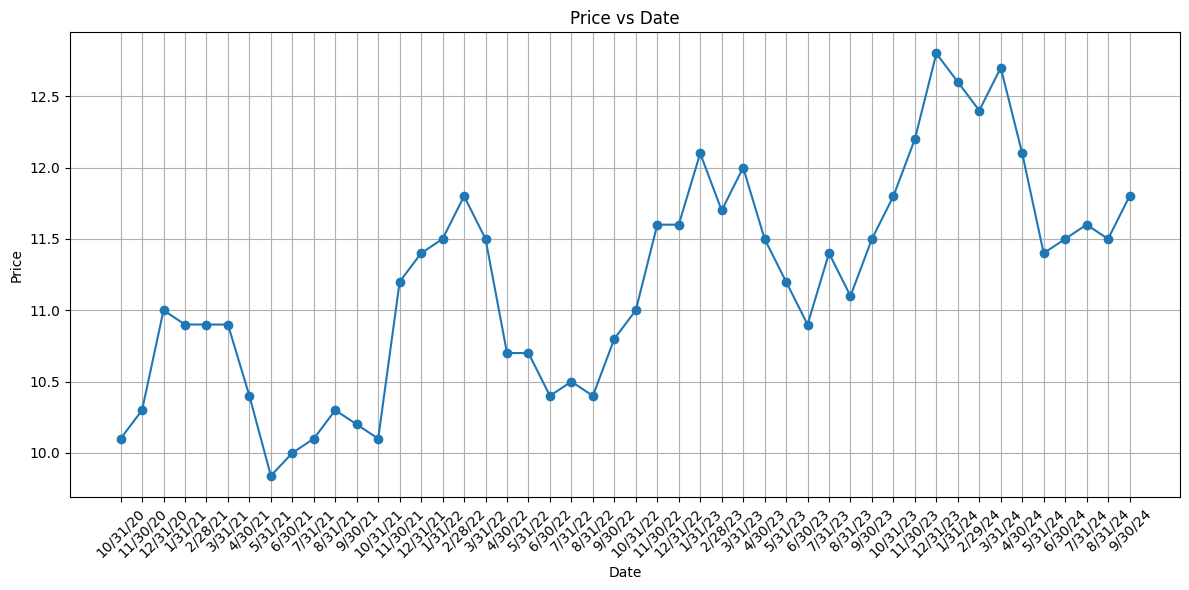

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Quantitative Research JP Morgan Chase & Co on the Forage/Nat_Gas.csv")

plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Prices'], marker='o')
plt.title('Price vs Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

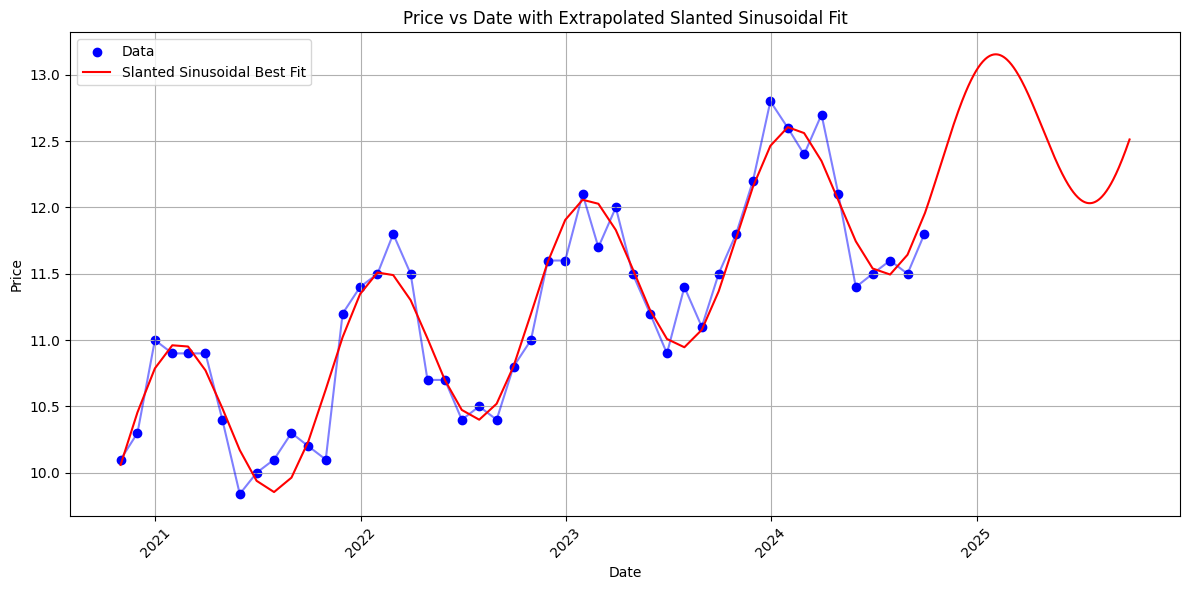

In [4]:
df['Dates'] = pd.to_datetime(df['Dates'])
df['Date_ordinal'] = df['Dates'].apply(lambda x: x.toordinal())

def slanted_sinusoidal(t, A, B, C, D, E):
    return A * np.sin(B * (t - C)) + D * t + E

# Provide an initial guess. This is just an example; you might need to adjust based on your data.
initial_guess = [
    (max(df['Prices']) - min(df['Prices'])) / 2, # Amplitude
    2 * np.pi / 365,                           # Frequency
    0,                                        # Phase shift
    0,                                        # Slope of the linear trend
    np.mean(df['Prices'])                      # y-intercept of the linear trend
]

params, covariance = curve_fit(slanted_sinusoidal, df['Date_ordinal'], df['Prices'], p0=initial_guess, maxfev=5000)

next_year_dates = pd.date_range(start=df['Dates'].iloc[-1] + timedelta(days=1), periods=365).to_frame(name='Dates')
next_year_dates['Date_ordinal'] = next_year_dates['Dates'].apply(lambda x: x.toordinal())

extended_dates = pd.concat([df[['Dates', 'Date_ordinal']], next_year_dates])

predicted_slanted_sinusoidal = slanted_sinusoidal(extended_dates['Date_ordinal'], *params)

plt.figure(figsize=(12, 6))

# Plot the original data with lines connecting the points
plt.scatter(df['Dates'], df['Prices'], color='blue', label='Data')
plt.plot(df['Dates'], df['Prices'], color='blue', alpha=0.5)  # This line connects the blue dots

# Plot the sinusoidal curve with linear trend for the entire duration (including next year)
plt.plot(extended_dates['Dates'], predicted_slanted_sinusoidal, color='red', label='Slanted Sinusoidal Best Fit')

plt.title('Price vs Date with Extrapolated Slanted Sinusoidal Fit')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

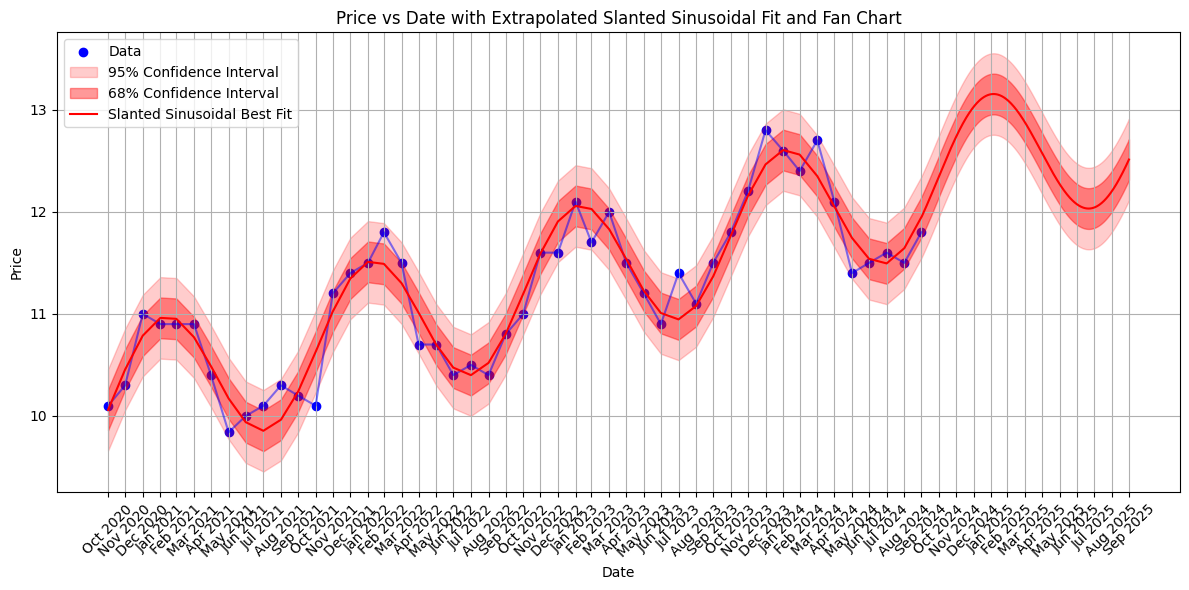

In [5]:
residuals = df['Prices'] - slanted_sinusoidal(df['Date_ordinal'], *params)

residual_std = np.std(residuals)

predicted_mean = slanted_sinusoidal(extended_dates['Date_ordinal'], *params)
lower_bound_1std = predicted_mean - residual_std
upper_bound_1std = predicted_mean + residual_std
lower_bound_2std = predicted_mean - 2 * residual_std
upper_bound_2std = predicted_mean + 2 * residual_std

monthly_ticks = pd.date_range(start=df['Dates'].iloc[0], end=extended_dates['Dates'].iloc[-1], freq='M')

plt.figure(figsize=(12, 6))

# Plot the original data with lines connecting the points
plt.scatter(df['Dates'], df['Prices'], color='blue', label='Data')
plt.plot(df['Dates'], df['Prices'], color='blue', alpha=0.5)  # Connecting lines

# Plot the confidence intervals
plt.fill_between(extended_dates['Dates'], lower_bound_2std, upper_bound_2std, color='red', alpha=0.2, label='95% Confidence Interval')
plt.fill_between(extended_dates['Dates'], lower_bound_1std, upper_bound_1std, color='red', alpha=0.4, label='68% Confidence Interval')

# Plot the sinusoidal curve with linear trend for the entire duration (including next year)
plt.plot(extended_dates['Dates'], predicted_mean, color='red', label='Slanted Sinusoidal Best Fit')

plt.title('Price vs Date with Extrapolated Slanted Sinusoidal Fit and Fan Chart')
plt.xlabel('Date')
plt.ylabel('Price')

# Set monthly divisions on the horizontal axis
plt.xticks(monthly_ticks, monthly_ticks.strftime('%b %Y'), rotation=45)

plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [6]:
def predict_price(date_str, params, residual_std):
    # Convert the date string to a pandas datetime object and then to its ordinal representation
    date_ordinal = pd.to_datetime(date_str).toordinal()

    # Predict the price for the given date using the slanted sinusoidal model
    predicted_mean = slanted_sinusoidal(date_ordinal, *params)

    # Calculate the confidence intervals
    lower_bound_1std = predicted_mean - residual_std
    upper_bound_1std = predicted_mean + residual_std
    lower_bound_2std = predicted_mean - 2 * residual_std
    upper_bound_2std = predicted_mean + 2 * residual_std

    return ((predicted_mean), (lower_bound_1std, upper_bound_1std), (lower_bound_2std, upper_bound_2std))

# Get user input for the date
date_input = input("Enter a date (in format YYYY-MM-DD): ")

# Call the predict_price function
pred_mean, conf_interval_1std, conf_interval_2std = predict_price(date_input, params, residual_std)

# Display the results
print(f"Predicted mean price for {date_input} is ${pred_mean:.2f}")
print(f"Predicted price for {date_input} with 68% confidence is between ${conf_interval_1std[0]:.2f} and ${conf_interval_1std[1]:.2f}")
print(f"Predicted price for {date_input} with 95% confidence is between ${conf_interval_2std[0]:.2f} and ${conf_interval_2std[1]:.2f}")

Enter a date (in format YYYY-MM-DD): 2025-05-12
Predicted mean price for 2025-05-12 is $12.45
Predicted price for 2025-05-12 with 68% confidence is between $12.25 and $12.65
Predicted price for 2025-05-12 with 95% confidence is between $12.05 and $12.85


# Task 2

**Background**

Great work! The desk now has the price data they need. The final ingredient before they can begin trading with the client is the pricing model. Alex tells you the client wants to start trading as soon as possible. They believe the winter will be colder than expected, so they want to buy gas now to store and sell in winter in order to take advantage of the resulting increase in gas prices. They ask you to write a script that they can use to price the contract. Once the desk are happy, you will work with engineering, risk, and model validation to incorporate this model into production code.

The concept is simple: any trade agreement is as valuable as the price you can sell minus the price at which you are able to buy. Any cost incurred as part of executing this agreement is also deducted from the overall value. So, for example, if I can purchase a million MMBtu of natural gas in summer at USD2/MMBtu, store this for four months, and ensure that I can sell the same quantity at USD3/MMBtu without incurring any additional costs, the value of this contract would be (USD3-USD2) *1e6 = USD1million. If there are costs involved, such as having to pay the storage facility owner a fixed fee of USD100K a month, then the 'value' of the contract, from my perspective, would drop by the overall rental amount to USD600K. Another cost could be the injection/withdrawal cost, like having to pay the storage facility owner USD10K per 1 million MMBtu for injection/withdrawal, then the price will further go down by USD10K to USD590K. Additionally, if I am supposed to foot a bill of $50K each time for transporting the gas to and from the facility, the cost of this contract would fall by another USD100K. Think of the valuation as a fair estimate at which both the trading desk and the client would be happy to enter into the contract.

**Task**

You need to create a prototype pricing model that can go through further validation and testing before being put into production. Eventually, this model may be the basis for fully automated quoting to clients, but for now, the desk will use it with manual oversight to explore options with the client.

You should write a function that is able to use the data you created previously to price the contract. The client may want to choose multiple dates to inject and withdraw a set amount of gas, so your approach should generalize the explanation from before. Consider all the cash flows involved in the product.

The input parameters that should be taken into account for pricing are:

Injection dates.
Withdrawal dates.
The prices at which the commodity can be purchased/sold on those dates.
The rate at which the gas can be injected/withdrawn.
The maximum volume that can be stored.
Storage costs.
Write a function that takes these inputs and gives back the value of the contract. You can assume there is no transport delay and that interest rates are zero. Market holidays, weekends, and bank holidays need not be accounted for. Test your code by selecting a few sample inputs.

In [8]:
def pricing_model():
    # Get the number of injections from the user
    num_injections = int(input("Enter the number of injections: "))
    injection_dates = {}
    for i in range(num_injections):
        date = input(f"Enter the injection date {i+1} (in format YYYY-MM-DD): ")
        quantity = float(input(f"Enter the quantity for injection date {i+1}: "))
        injection_dates[date] = quantity

    # Get the number of withdrawals from the user
    num_withdrawals = int(input("Enter the number of withdrawals: "))
    withdrawal_dates = {}
    for i in range(num_withdrawals):
        date = input(f"Enter the withdrawal date {i+1} (in format YYYY-MM-DD): ")
        quantity = float(input(f"Enter the quantity for withdrawal date {i+1}: "))
        withdrawal_dates[date] = quantity

    # Get other parameters from the user
    inject_rate = float(input("Enter the injection rate: "))
    withdrawal_rate = float(input("Enter the withdrawal rate: "))
    max_vol = float(input("Enter the maximum storage volume: "))
    storage_costs = float(input("Enter the monthly storage costs: "))

    # Calculate Injection Costs
    injection_costs = sum([(inject_rate + predicted_mean(date)) * quantity for date, quantity in injection_dates.items()])

    # Calculate Withdrawal Revenues
    withdrawal_revenues = sum([(predicted_mean(date) - withdrawal_rate) * quantity for date, quantity in withdrawal_dates.items()])

    # Check Max Volume and Calculate Storage Costs
    total_volume = 0
    all_dates = sorted(list(injection_dates.keys()) + list(withdrawal_dates.keys()))
    for date in all_dates:
        total_volume += injection_dates.get(date, 0)
        total_volume -= withdrawal_dates.get(date, 0)
        if total_volume > max_vol:
            return "Max volume exceeded!"

        if total_volume < 0:  # Check for negative volumes (indicating more was withdrawn than injected)
            return f"Cannot withdraw more than injected on date {date}."

    months_between = (pd.to_datetime(all_dates[-1]) - pd.to_datetime(all_dates[0])).days // 30
    storage_fee = months_between * storage_costs

    if total_volume != 0:  # Volume isn't zero at the end
        print(f"Warning: There will still be storage costs associated after the final withdrawal for {total_volume} units.")

    # Calculate the net value
    net_value = withdrawal_revenues - injection_costs - storage_fee

    print(f"Value of the contract: ${net_value:.2f}")

    return net_value

# Predicted Mean Price Function using previously defined `predict_price`
def predicted_mean(date_str):
    return predict_price(date_str, params, residual_std)[0]  # Get the predicted mean from predict_price

# Call the pricing_model function
pricing_model()


Enter the number of injections: 1
Enter the injection date 1 (in format YYYY-MM-DD): 2020-12-20
Enter the quantity for injection date 1: 10
Enter the number of withdrawals: 2
Enter the withdrawal date 1 (in format YYYY-MM-DD): 2022-11-30
Enter the quantity for withdrawal date 1: 5
Enter the withdrawal date 2 (in format YYYY-MM-DD): 2024-01-12
Enter the quantity for withdrawal date 2: 5
Enter the injection rate: 1
Enter the withdrawal rate: 0.1
Enter the maximum storage volume: 19
Enter the monthly storage costs: 0.01
Value of the contract: $2.44


2.4446783922150006

# Task 3

**Background**

You have now moved to a new team assisting the retail banking arm, which has been experiencing higher-than-expected default rates on personal loans. Loans are an important source of revenue for banks, but they are also associated with the risk that borrowers may default on their loans. A default occurs when a borrower stops making the required payments on a debt.

The risk team has begun to look at the existing book of loans to see if more defaults should be expected in the future and, if so, what the expected loss will be. They have collected data on customers and now want to build a predictive model that can estimate the probability of default based on customer characteristics. A better estimate of the number of customers defaulting on their loan obligations will allow us to set aside sufficient capital to absorb that loss. They have decided to work with you in the QR team to help predict the possible losses due to the loans that would potentially default in the next year.

Charlie, an associate in the risk team, who has been introducing you to the business area, sends you a small sample of their loan book and asks if you can try building a prototype predictive model, which she can then test and incorporate into their loss allowances.

**Task**

The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.
Submit your code below.

In [9]:
df = pd.read_csv("/content/drive/MyDrive/Quantitative Research JP Morgan Chase & Co on the Forage/Task 3 and 4_Loan_Data.csv")

# Extracting the desired features and target variable
features = df.columns[1:7].tolist()
X = df[features].copy()
y = df['default']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on test data & Evaluate the accuracy
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest model: {accuracy:.2f}")

Accuracy of the Random Forest model: 0.99


In [11]:
def calculate_expected_loss(rf_clf, feature_names):
    # Taking input from the user for the relevant features
    print("Enter the loan data for prediction:")
    loan_data = [float(input(f"Enter value for {col}: ")) for col in feature_names]

    # Calculating the Probability of Default
    PD = rf_clf.predict_proba([loan_data])[0][1]

    # Given recovery rate
    recovery_rate = 0.10
    LGD = 1 - recovery_rate

    # Assuming Exposure at Default (EAD) is the total amount of the loan.
    # You may want to adjust this if there's a specific column for the loan amount.
    EAD_index = feature_names.index('loan_amt_outstanding')
    EAD = loan_data[EAD_index]

    # Expected Loss
    EL = PD * LGD * EAD
    print(f"Expected Loss for the loan is: ${EL:.2f}")

    return EL

# Call the function to calculate expected loss
calculate_expected_loss(rf_clf, features)

Enter the loan data for prediction:
Enter value for credit_lines_outstanding: 2
Enter value for loan_amt_outstanding: 1000
Enter value for total_debt_outstanding: 2100
Enter value for income: 17000
Enter value for years_employed: 2
Enter value for fico_score: 450
Expected Loss for the loan is: $156.22


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


156.2160068437394

# Task 4

**Background**

Now that you are familiar with the portfolio and personal loans and risk are using your model as a guide to loss provisions for the upcoming year, the team now asks you to look at their mortgage book. They suspect that FICO scores will provide a good indication of how likely a customer is to default on their mortgage. Charlie wants to build a machine learning model that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires categorical data. As FICO ratings can take integer values in a large range, they will need to be mapped into buckets. She asks if you can find the best way of doing this to allow her to analyze the data.

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors. FICO scores are used in 90% of mortgage application decisions in the United States. The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to construct a technique for predicting the PD (probability of default) for the borrowers using these scores.

**Task**

Charlie wants to make her model work for future data sets, so she needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model, she would like to find out the boundaries that best summarize the data. You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

The process of doing this is known as quantization. You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood (see below for definitions). For background on quantization, see here.

Mean squared error

You can view this question as an approximation problem and try to map all the entries in a bucket to one value, minimizing the associated squared error. We are now looking to minimize the following:

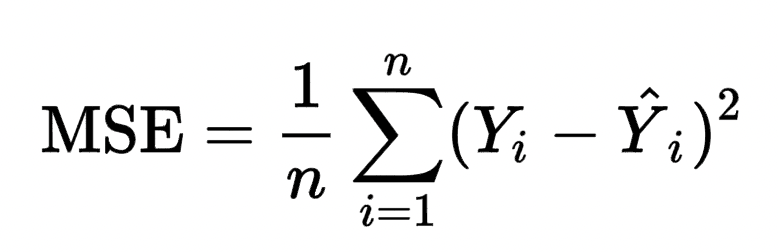

In [ ]:
# Load the Data
path = '/content/drive/MyDrive/Quantitative Research JP Morgan Chase & Co on the Forage/Task 3 and 4_Loan_Data.csv'
data = pd.read_csv(path)
fico_scores = data['fico_score'].values

# User Input for Number of Buckets
try:
    N = int(input("Please enter the number of buckets you'd like: "))
except ValueError:
    print("Please enter a valid integer for the number of buckets.")
    N = 5  # Default value

# Normalize the fico scores
normalized_scores = (fico_scores - 300) / (850 - 300)  # Using known FICO score range

# Display FICO score boundaries before optimization
print("\nFICO score boundaries before optimization:", [300, 850])  # Fixed values for FICO

# Apply K-means clustering
kmeans = KMeans(n_clusters=N, random_state=0).fit(normalized_scores.reshape(-1, 1))
data['bucket_labels'] = kmeans.labels_

# Sort the cluster centers in descending order
sorted_centers_after = sorted([(index, center) for index, center in enumerate(kmeans.cluster_centers_.flatten())], key=lambda x: x[1], reverse=True)

# Assign ratings normalized between 0 and 1
ratings = {entry[0]: index/(N-1) for index, entry in enumerate(sorted_centers_after)}
data['ratings'] = data['bucket_labels'].apply(lambda x: ratings[x])

# Compute and print FICO boundaries after optimization
bucket_minima_after = data.groupby('ratings')['fico_score'].min().values
print("\nFICO boundaries after optimization:", sorted([300] + list(bucket_minima_after) + [850]))  # Include fixed values for FICO

# Display ratings for each bucket
print("\nRatings for each bucket:")
for rating, boundary in zip(sorted(data['ratings'].unique()), sorted(bucket_minima_after)):
    print(f"Boundary: {boundary}, Rating: {rating}")

# Calculate MSE for Each Bucket
def calculate_mse(bucket):
    cluster_center = kmeans.cluster_centers_[bucket['bucket_labels'].iloc[0]]
    return np.mean((bucket['normalized_fico'] - cluster_center) ** 2)

data['normalized_fico'] = normalized_scores
mse_values = data.groupby('bucket_labels').apply(calculate_mse)
print("\nMean Squared Error values for each bucket:")
print(mse_values)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please enter the number of buckets you'd like: 12

FICO score boundaries before optimization: [300, 850]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



FICO boundaries after optimization: [300, 408, 507, 544, 573, 598, 619, 637, 656, 676, 699, 726, 763, 850]

Ratings for each bucket:
Boundary: 408, Rating: 0.0
Boundary: 507, Rating: 0.09090909090909091
Boundary: 544, Rating: 0.18181818181818182
Boundary: 573, Rating: 0.2727272727272727
Boundary: 598, Rating: 0.36363636363636365
Boundary: 619, Rating: 0.45454545454545453
Boundary: 637, Rating: 0.5454545454545454
Boundary: 656, Rating: 0.6363636363636364
Boundary: 676, Rating: 0.7272727272727273
Boundary: 699, Rating: 0.8181818181818182
Boundary: 726, Rating: 0.9090909090909091
Boundary: 763, Rating: 1.0

Mean Squared Error values for each bucket:
bucket_labels
0     0.000318
1     0.000122
2     0.000340
3     0.000112
4     0.000134
5     0.000166
6     0.001039
7     0.000216
8     0.001184
9     0.000091
10    0.000193
11    0.000099
dtype: float64


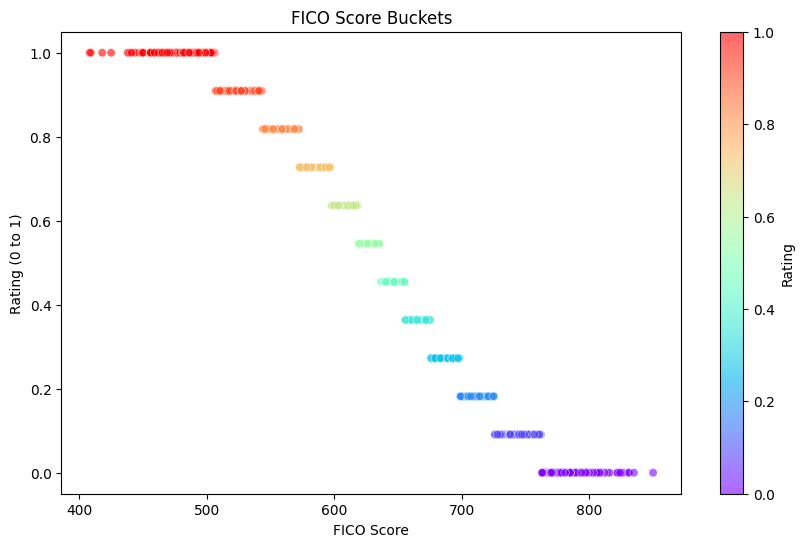

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.scatter(data['fico_score'], data['ratings'], c=data['ratings'], cmap='rainbow', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('FICO Score')
plt.ylabel('Rating (0 to 1)')
plt.title('FICO Score Buckets')
plt.colorbar(label='Rating')
plt.show()